# Classification as a Black Box

In these notes, we'll make a lightning tour through the "standard workflow" for users of predictive machine learning technologies. Our focus will be on out-of-the-box Python tools for acquiring, visualizing, and analyzing tabular data sets. 

We're going to move pretty quickly through some big topics in practical data science: acquiring data, data visualization, data manipulation, and prediction using the Scikit-Learn package. Throughout these notes, I've sprinkled references to the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) [@vanderplasPythonDataScience2016], which treats many of these practical considerations in much greater detail. 

## Classifying the Palmer Penguins

![Image source: \@allisonhorst](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

Our data set for these notes is Palmer Penguins. This data set contains physiological measurements and species labels for several populations of Adelie, Chinstrap, and Gentoo penguins. 

[The Palmer Penguins data was originally collected by @gormanEcologicalSexualDimorphism2014 and was nicely packaged and released for use in the data science community by @horstAllisonhorstPalmerpenguinsV02020. You can find [a very concise summary](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Supervised-learning-example:-Iris-classification) of the main workflow using a similar data set in @vanderplasPythonDataScience2016.]{.aside}. 

Let's go ahead and acquire the data. 

In [1]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/palmer-penguins.csv"

In [3]:
df = pd.read_csv(url)

[You can learn much more about the capabilities of `pandas.DataFrame` objects in [Chapter 3](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html) of  @vanderplasPythonDataScience2016]{.aside}
The `df` variable holds a `pandas.DataFrame` object. You can think of a data frame as a table of data with a variety of useful behaviors for data manipulation and visualization. 

Let's take a look: 

In [6]:
df.head() #look at 5 rows of df

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


It's always useful to get acquainted with the "basics" of the data. For example, how many rows and columns do we have?

In [8]:
df.shape #tells us how big data is (the rows,penguins, and columns)

(344, 17)

What are the data types of the columns? [`str` columns are represented with the generic `object` in Pandas.]{.aside}

In [9]:
df.dtypes #tells us about the data types on each column on dataframe

studyName               object
Sample Number            int64
Species                 object
Region                  object
Island                  object
Stage                   object
Individual ID           object
Clutch Completion       object
Date Egg                object
Culmen Length (mm)     float64
Culmen Depth (mm)      float64
Flipper Length (mm)    float64
Body Mass (g)          float64
Sex                     object
Delta 15 N (o/oo)      float64
Delta 13 C (o/oo)      float64
Comments                object
dtype: object

Here's the question we'll ask today about this data set: 

> Given some physiological measurements of a penguin, can we reliably infer its species? 

## Data Preparation

[We can select our desired columns from the data frame, operate on them, and make assignments to them using the [data-frame-as-dictionary paradigm](https://jakevdp.github.io/PythonDataScienceHandbook/03.02-data-indexing-and-selection.html#Data-Selection-in-DataFrame) explored in @vanderplasPythonDataScience2016.]{.aside}

In applied data science, at least 80% of the work is typically spent acquiring and preparing data. Here, we're going to do some simple data preparation directed by our question. It's going to be convenient to shorten the `Species` column for each penguin. Furthermore, for visualization purposes today we are going to focus on the `Culmen Length (mm)` and `Culmen Depth (mm)` columns. 


In [10]:
df = df[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Species']]#indexing df

df = df.dropna() #remvoing NA preguins from dataset

# slightly advanced syntax: 
# replace the column with the first word in each entry
df["Species"] = df["Species"].str.split().str.get(0)

Let's take a look at what we've done so far: 

In [11]:
df.head()

,Culmen Length (mm),Culmen Depth (mm),Species
0,39.1,18.7,Adelie
1,39.5,17.4,Adelie
2,40.3,18.0,Adelie
4,36.7,19.3,Adelie
5,39.3,20.6,Adelie


As another preprocessing step, we are going to add transformed labels represented as integers. 

In [12]:
# for later: assign an integer to each species
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder() #this creates new cols that save to df 
df["species_label"] = le.fit_transform(df["Species"]) #col represents species

for i, c in enumerate(le.classes_):
    print(f"Class number {i} represents {c} penguins.")

Class number 0 represents Adelie penguins.
Class number 1 represents Chinstrap penguins.
Class number 2 represents Gentoo penguins.


Now our data looks like this: 

In [13]:
df.head()

,Culmen Length (mm),Culmen Depth (mm),Species,species_label
0,39.1,18.7,Adelie,0
1,39.5,17.4,Adelie,0
2,40.3,18.0,Adelie,0
4,36.7,19.3,Adelie,0
5,39.3,20.6,Adelie,0


### Train-Test Split

When designing predictive models, it's important to *evaluate* them in a context that simulates the prediction application as accurately as possible. One important way we do this is by performing a *train-test split*. We keep most of the data as *training data* which we'll use to design the model. We'll hold out a bit of the data as *testing data*, which we'll treat as unseen and only use once we are ready to evaluate our final design. The testing data simulates the idea of "new, unseen data" -- exactly the kind of data on which it would be useful for us to make predictions!

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2)

Let's check the size of our two split data sets: 

In [15]:
df_train.shape, df_test.shape

((273, 4), (69, 4))

Now we're going to forget that `df_test` exists for a while. Instead, we'll turn our attention to analysis, visualization and modeling. 

## Data Analysis and Visualization

As a first step, it's useful to understand how many of each species there are in the training data: 

[This is an example of a "split-apply-combine" operation [@wickhamSplitApplyCombineStrategyData2011]. We split the dataframe into three groups depending on the species label, apply an operation (in this case, computing the number of rows), and then combine the results into a single object. Pandas implements split-apply-combine primarily through the [`groupby` method](https://pandas.pydata.org/docs/user_guide/groupby.html) and several associated functions. There are [some nice examples of split-apply-combine](https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html) in Pandas in @vanderplasPythonDataScience2016.]{.aside}

There are more Adelie penguins than Chintraps or Gentoos in this data set. Here are the proportions: 

So, over 40% of the penguins in the data are Adelie penguins. One important consequence of this proportion is the *base rate* of the classification problem. The base rate refers to how well we could perform at prediction if we did not use any kind of predictive modeling, but instead simply predicted the most common class for every penguin. Here, if we always predicted "Adelie" for the species, we'd expect to be right more than 40% of the time. So, a minimal expectation of anything fancier we do is that it should be correct much more than 40% of the time. 

Now let's take a look at our (training) data and see whether our chosen columns look like they have a chance of predicting the penguin species. 
We'll show the plot both without and with the species labels. 


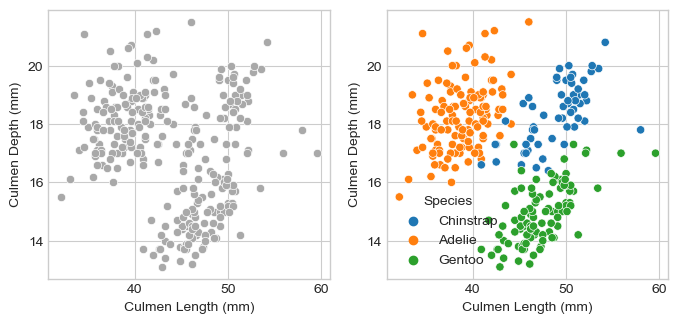

In [16]:
#| fig-cap: These plots are generated using the [Seaborn library](https://seaborn.pydata.org/) for Python. Seaborn is a high-level wrapper around the classical [matplotlib](https://matplotlib.org/) library for data visualization. Although Matplotlib is very flexible, Seaborn is optimized for visualizing data contained in Pandas data frames. You can find many examples of creating Seaborn plots in the [official gallery](https://seaborn.pydata.org/examples/index.html), and [many tips and examples for matplotlib](https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html) in @vanderplasPythonDataScience2016. 

from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

p1 = sns.scatterplot(df_train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", ax = ax[0], color = "darkgrey")
p2 = sns.scatterplot(df_train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue = "Species", ax = ax[1])

We can think of the lefthand side as "what the model will see:" just physiological measurements with no labels. On the right we can see the data with its species labels included. We can see that the species are divided into clusters: Adelie penguins have measurements which tend to be similar to other Adelies; Chinstraps are similar to other Chinstraps, etc. 

This pattern is promising! The approximate separation of the species suggests that a machine learning model which predicts the species label from these measurements is likely to be able to beat the base rate. 

## Modeling and Model Selection

Let's go ahead and fit some models! We're going to fit two models that are pre-implemented in the package `scikit-learn`. For now, you can think of these models as black-box algorithms that accept *predictor variables* as inputs and return a *predicted target* as an output. In our case, the predictor variables are the culmen length and culmen depth columns, while the target we are attempting to predict is the species. Later on, we'll learn more about how some of these models actually work. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier
from mlxtend.plotting import plot_decision_regions # for visualization later

It's convenient to split our data into predictors $\mathbf{X}$ and targets $\mathbf{y}$. We need to do this once for each of the training and test sets. 

In [18]:
predictor_cols = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_col = "species_label"

X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_test = df_test[predictor_cols]
y_test = df_test[target_col]

Let's take a quick look at `X_train`

In [19]:
X_train #shows prediction data. what we will use to make predictions
#y_train

,Culmen Length (mm),Culmen Depth (mm)
207,52.2,18.8
38,37.6,19.3
221,50.0,16.3
232,45.5,13.7
49,42.3,21.2
...,...,...
81,42.9,17.6
103,37.8,20.0
112,39.7,17.7
171,49.2,18.2


[We'll go in-depth on logistic regression later in this course.]{.aside}

Now we're ready to fit our first machine learning model. Let's try logistic regression! In the Scikit-learn API, we first need to instantiate the `LogisticRegression()` class, and then call the `fit()` method of this class on the training predictors and targets. 

In [21]:
LR = LogisticRegression() #instantiate LR object
m = LR.fit(X_train, y_train)

So, uh, did it work? The `LogisticRegression()` class includes a handy method to compute the accuracy of the classifier: 

In [26]:
LR.coef_ #matrix of parameters that represent the patterns the model has learned

#did we learn patterns in data? compute score to find out
LR.score(X_train, y_train) #score measures accuracy: how often was I right?

0.9633699633699634

Wow! Much better than the base rate. Note that this is the accuracy on the *training data*. In theory, accuracy on the test data could look very different. 

A useful way to visualize models with two numerical predictors is via *decision regions*. Each region describes the set of possible measurements that would result in a given classification. 

[You can unfold this code to see a simple implementation of a function for plotting decision regions which wraps [the `plot_decision_regions` function](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) of the `mlxtend` package. ]{.aside}

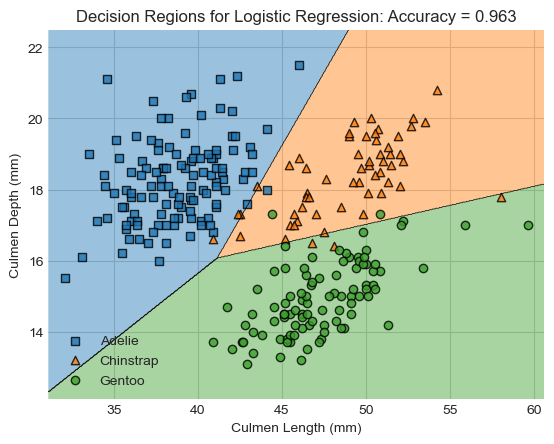

In [27]:
#| code-fold: true

def decision_regions(X, y, model, title):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plot_decision_regions(X_train.to_numpy(), y_train.to_numpy(), clf = model, legend = 2)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, 
                le.classes_, 
                framealpha=0.3, scatterpoints=1)

        ax.set(xlabel = "Culmen Length (mm)", ylabel = "Culmen Depth (mm)", title = f"{title}: Accuracy = {model.score(X, y):.3f}")

decision_regions(X_train, y_train, LR, "Decision Regions for Logistic Regression")

[You can [learn more about how support vector machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html) work in @vanderplasPythonDataScience2016. We'll also study these models later in the course.]{.aside}

While we're at it, let's try fitting a different classifier, also supplied by Scikit-learn. This classifier is called *support vector machine* (SVM). 


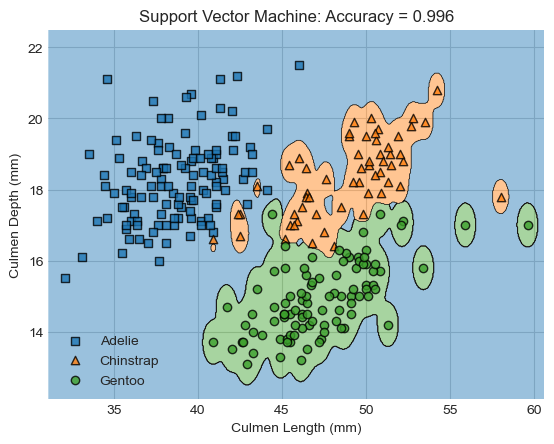

In [28]:
#using support vector machine
SVM = SVC(gamma = 5)
SVM.fit(X_train, y_train)
decision_regions(X_train, y_train, SVM, 'Support Vector Machine')

#created an overfit graph. generalizing bc any penguin in the 55/14 point would be classified as an Adeline instead of a Gentoo


Wow! The support vector machine classifier achieved even higher accuracy on the training data. This is enabled by the greater *flexibility* of the SVM. Flexibility comes from a lot of places in machine learning, and generally refers to the ability of models to learn complicated decision boundaries like the ones shown here. 

But is this increased flexibility a good thing? You might look at this predictor and think that something funny is going on. For example, shouldn't a point on the bottom right be more likely to be a Gentoo penguin than an Adelie?...

#### Simulating Evaluation: Cross-Validation

Now we have two competing classification models: logistic regression and support vector machine. Which one is going to do the best job of prediction on totally new, unseen data? We could go ahead and evaluate on our test set, but for statistical reasons we need to avoid doing this until we've made a final choice of classifier. 

[@vanderplasPythonDataScience2016 has [more on cross-validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html) and overfitting. We'll confront overfitting agian many times in this course.]{.aside}

In order to make an assessment, we can simulate the process of fitting the model and evaluating on "test" data by witholding parts of our *training* data to use as testing. We split the data into chunks and withold each chunk, using the other chunks to train the data. This is called *cross-validation*, and it is illustrated in this figure: 

![Image source: [scikit-learn](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png) ](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

We could do this with a janky for-loop, but the nice `scikit-learn` developers have implemented this for us. Here's an example of cross-validation with 5 folds. This can take a little while, as there are actually 5 calls to `model.fit()` happening under the hood each time. 

In [29]:
from sklearn.model_selection import cross_val_score #write this isntead of for-loop

First let's compute the cross-validation accuracies for logistic regression: 

In [30]:
cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5) #training on remaining 80% of data
cv_scores_LR

array([0.927, 1.   , 0.945, 0.944, 0.963])

A convenient way to summarize these results is by computing the average: 

In [31]:
cv_scores_LR.mean()

0.9560269360269359

Let's compare to SVM: 

In [33]:
cv_scores_SVM = cross_val_score(SVM, X_train, y_train, cv = 5) #100/5 = 20% 
cv_scores_SVM.mean()

0.8643097643097641

Ah! It looks like our SVM classifier was indeed *too flexible* to do well in predicting data that it hasn't seen before. Although the SVM had better training accuracy than the logistic regression model, it failed to *generalize* to the task of unseen prediction. This phenomenon is called *overfitting*. Dealing with overfitting is one of the fundamental modeling challenges in applied machine learning. 

## Model Evaluation

So far, we've fit a logistic regression model and a support vector machine model; compared the two on a cross-validation task; and determined that the logistic regression model is most likely to generalize. Let's now retrain the logistic regression model on the complete training data and finally evaluate it on the test set: 

In [35]:
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

#estimate of performance

0.9710144927536232

Not bad! This is our final estimate for the accuracy of our model as a classification tool on unseen penguin data.

### Beyond Accuracy

Accuracy is a simple measure of how many errors a model makes. In many applications, it's important to understand what *kind* of errors the model makes, a topic which we'll study much more when we come to decision theory in the near future. We can get a quick overview of the kinds of mistakes that a model makes by computing the *confusion matrix* between the true labels and predictions. This matrix cross-tabulates all the true labels with all the predicted ones. 

In [38]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test)
#y_test_pred
C = confusion_matrix(y_test, y_test_pred)
C
#each row says the penguin's true predictions adeline, chinstrap, gentoo
#30 adeline classifed as adeline, one instance of adeline misclassidfied as chinstrap, etc

array([[30,  1,  0],
       [ 0, 10,  1],
       [ 0,  0, 27]])

The entry in the `i`th row and `j`th column of the confusion matrix gives the number of data points that have true label `i` and predicted label `j` from our model. 

In [ ]:
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

## Recap

In these notes, we took a very quick tour of the core data science workflow. We considered a simple classification problem in which we acquired some data, cleaned it up a bit, visualized several of its features, used those features to make a predictive classification model, visualized that model, and evaluated its accuracy. Along the way, we encountered the phenomenon of *overfitting*: models that are too flexible will achieve remarkable accuracy on the training set but will generalize poorly to unseen data. The problem of designing models that are "flexible enough" and "in the right way" is a fundamental driving force in modern machine learning, and the deep learning revolution can be viewed as the latest paradigm for seeking appropriately flexible models. 

So far, we haven't attempted to understand how any of these predictive models actually *work*. We'll dive into this topic soon.

## References
